In [1]:
import os
import errno

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import bn_feature_net_3D
from deepcell.model_zoo import bn_feature_net_61x61_3D
from deepcell.model_zoo import bn_feature_net_skip_3D
from deepcell.training import train_model_sample

Using TensorFlow backend.


## Load the Training Data

In [2]:
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 15  # get first N frames from each training folder

WIN_X = 30
WIN_Y = 30
WIN_Z = 2

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
DATA_FILE = 'MouseBrain_3d_{}'.format(K.image_data_format())

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # all training directories
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=NUM_FRAMES,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')


Data saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain_3d_channels_last.npz


# Sample Based Training

In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 5
batch_size = 128
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (220, 15, 256, 256, 1)
y.shape: (220, 15, 256, 256, 1)


In [5]:
# First, create a foreground/background separation model

# Instantiate the model
sample_model = bn_feature_net_61x61_3D(
    n_features=4,  # (background edge, interior edge, cell interior, background)
    n_frames=2 * WIN_Z + 1,
    norm_method='whole_image',
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample(
    model=sample_model,
    expt='sample',
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    transform='deepcell',
    dilation_radius=None,
    window_size=(WIN_X, WIN_Y, WIN_Z),
    balance_classes=True,
    max_class_samples=1e5,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 4)
Number of Classes: 4
Epoch 1/5
2333/2334 [============================>.] - ETA: 0s - loss: 0.8287 - acc: 0.6315
Epoch 00001: val_loss improved from inf to 0.74959, saving model to /data/models/cells/MouseBrain/generic/2018-09-05_MouseBrain_3d_channels_last_sample.h5
2334/2334 [==============================] - 680s 291ms/step - loss: 0.8286 - acc: 0.6315 - val_loss: 0.7496 - val_acc: 0.6854
Epoch 2/5
2333/2334 [============================>.] - ETA: 0s - loss: 0.7519 - acc: 0.6754
Epoch 00002: val_loss did not improve
2334/2334 [==============================] - 674s 289ms/step - loss: 0.7518 - acc: 0.6754 - val_loss: 0.7825 - val_acc: 0.7004
Epoch 3/5
2333/2334 [============================>.] - ETA: 0s - loss: 0.6802 - acc: 0.7127
Epoch 00003: val_loss did not improve
2334/2334 [==============================] - 6

In [6]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='conv', seed=21)

# too many batches at once causes OOM
X_test, y_test = test_dict['X'][:4], test_dict['y'][:4]

# To predict on variable number of frames
# we need to re-instantiate model and load weights
sample_weights_file = '2018-09-05_MouseBrain_3d_channels_last_sample.h5'
sample_weights_file = os.path.join(MODEL_DIR, PREFIX, sample_weights_file)

run_sample_model = bn_feature_net_61x61_3D(
    n_features=4,
    dilated=True,
    n_frames=2 * WIN_Z + 1,
    input_shape=X_test.shape[1:],
    norm_method='whole_image')
run_sample_model.load_weights(sample_weights_file)

test_images_sample = run_sample_model.predict(X_test)

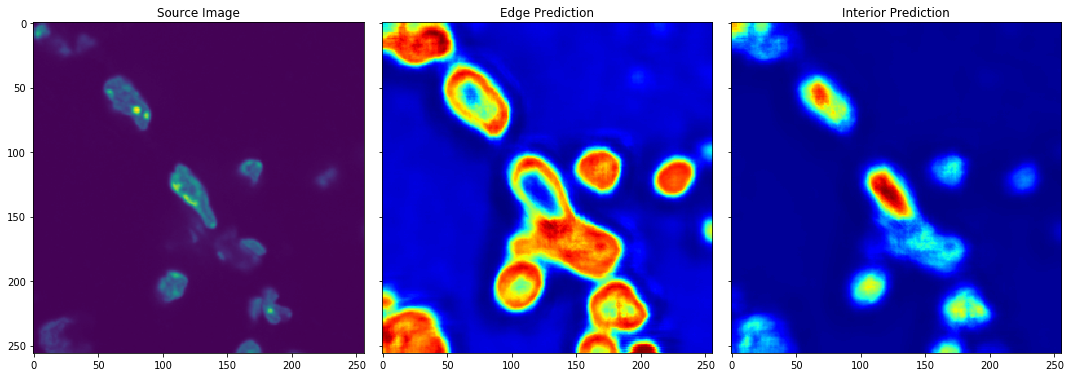

In [9]:
# Plot the results
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 0
frame = 5

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_sample[index, frame, :, :, 0] + test_images_sample[index, frame, :, :, 1], cmap='jet')
ax[1].set_title('Edge Prediction')

ax[2].imshow(test_images_sample[index, frame, :, :, 2], cmap='jet')
ax[2].set_title('Interior Prediction')

fig.tight_layout()
plt.show()

In [10]:
from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML

HTML(get_js_video(test_images_sample, batch=0, channel=2))